In [1]:
import pandas as pd
import numpy as np
import re
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    print(f"Dataset loaded with shape: {df.shape}")
    print(f"Column names: {df.columns.tolist()}")
    return df

In [3]:
def extract_url_features(url):
    features = {}

    # Basic URL features
    features['url_length'] = len(url)
    features['domain_length'] = len(urlparse(url).netloc)
    features['path_length'] = len(urlparse(url).path)

    # Character features
    features['digit_count'] = sum(c.isdigit() for c in url)
    features['letter_count'] = sum(c.isalpha() for c in url)
    features['digit_letter_ratio'] = features['digit_count'] / max(features['letter_count'], 1)
    features['special_char_count'] = sum(not c.isalnum() for c in url)

    # Domain features
    parsed_url = urlparse(url)
    domain = parsed_url.netloc

    features['domain_hyphen_count'] = domain.count('-')
    features['domain_digit_count'] = sum(c.isdigit() for c in domain)
    features['subdomain_count'] = domain.count('.')

    # Path features
    path = parsed_url.path
    features['path_slash_count'] = path.count('/')
    features['directory_length'] = len(path.split('/'))

    # Protocol
    features['is_https'] = 1 if parsed_url.scheme == 'https' else 0

    # Query
    query = parsed_url.query
    features['has_query'] = 1 if len(query) > 0 else 0
    features['query_length'] = len(query)
    features['query_param_count'] = query.count('&') + 1 if query else 0

    # Special patterns often found in malicious URLs
    suspicious_patterns = [
        'login', 'admin', 'banking', 'secure', 'account', 'validation', 'authenticate',
        'signin', 'verify', 'update', 'confirm', 'paypal', 'password', 'username'
    ]
    url_lower = url.lower()
    features['suspicious_word_count'] = sum(pattern in url_lower for pattern in suspicious_patterns)

    # TLD features
    try:
        features['tld'] = domain.split('.')[-1] if '.' in domain else ''
        features['tld_length'] = len(features['tld'])
    except:
        features['tld'] = ''
        features['tld_length'] = 0

    # URL shortening services
    shortening_services = [
        'bit.ly', 'goo.gl', 'tinyurl.com', 't.co', 'is.gd', 'cli.gs', 'ow.ly',
        'yfrog.com', 'migre.me', 'ff.im', 'tiny.cc', 'url4.eu', 'twit.ac', 'su.pr',
        'twurl.nl', 'snipurl.com', 'short.to', 'budurl.com', 'ping.fm', 'post.ly'
    ]
    features['is_shortened'] = 1 if any(service in domain for service in shortening_services) else 0

    # Check for IP address instead of domain name
    ip_pattern = r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}'
    features['has_ip'] = 1 if re.search(ip_pattern, domain) else 0

    # Count of certain special characters often found in malicious URLs
    features['at_symbol_count'] = url.count('@')
    features['double_slash_count'] = url.count('//')
    features['question_mark_count'] = url.count('?')
    features['equal_sign_count'] = url.count('=')
    features['semicolon_count'] = url.count(';')

    # Features based on URL entropy (randomness)
    char_count = {}
    for c in url:
        char_count[c] = char_count.get(c, 0) + 1

    url_entropy = 0
    for count in char_count.values():
        probability = count / len(url)
        url_entropy -= probability * np.log2(probability)

    features['url_entropy'] = url_entropy

    return features

In [4]:
def create_feature_dataframe(df, url_column='url', label_column='label'):
    feature_list = []

    for index, row in df.iterrows():
        url = row[url_column]
        label = row[label_column]

        features = extract_url_features(url)
        features['label'] = label
        feature_list.append(features)

        # Print progress
        if index % 1000 == 0:
            print(f"Processed {index} URLs...")

    feature_df = pd.DataFrame(feature_list)
    return feature_df

In [5]:
def visualize_feature_importance(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(12, 8))
    plt.title('Feature Importances')
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

In [6]:
def train_and_evaluate_model(model, model_name, X, X_train, X_test, y_train, y_test, label_encoder):
    print(f"\nTraining {model_name}...")
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    print(f"{model_name} training finished in {(end_time - start_time):.2f} seconds.")

    # Predictions
    y_pred = model.predict(X_test)

    # Evaluation
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    # Feature importance
    if hasattr(model, 'feature_importances_'):
        visualize_feature_importance(model, X.columns)

    return model

Dataset loaded with shape: (651191, 2)
Column names: ['url', 'type']
Extracting features from URLs...
Processed 0 URLs...
Processed 1000 URLs...
Processed 2000 URLs...
Processed 3000 URLs...
Processed 4000 URLs...
Processed 5000 URLs...
Processed 6000 URLs...
Processed 7000 URLs...
Processed 8000 URLs...
Processed 9000 URLs...
Processed 10000 URLs...
Processed 11000 URLs...
Processed 12000 URLs...
Processed 13000 URLs...
Processed 14000 URLs...
Processed 15000 URLs...
Processed 16000 URLs...
Processed 17000 URLs...
Processed 18000 URLs...
Processed 19000 URLs...
Processed 20000 URLs...
Processed 21000 URLs...
Processed 22000 URLs...
Processed 23000 URLs...
Processed 24000 URLs...
Processed 25000 URLs...
Processed 26000 URLs...
Processed 27000 URLs...
Processed 28000 URLs...
Processed 29000 URLs...
Processed 30000 URLs...
Processed 31000 URLs...
Processed 32000 URLs...
Processed 33000 URLs...
Processed 34000 URLs...
Processed 35000 URLs...
Processed 36000 URLs...
Processed 37000 URLs...

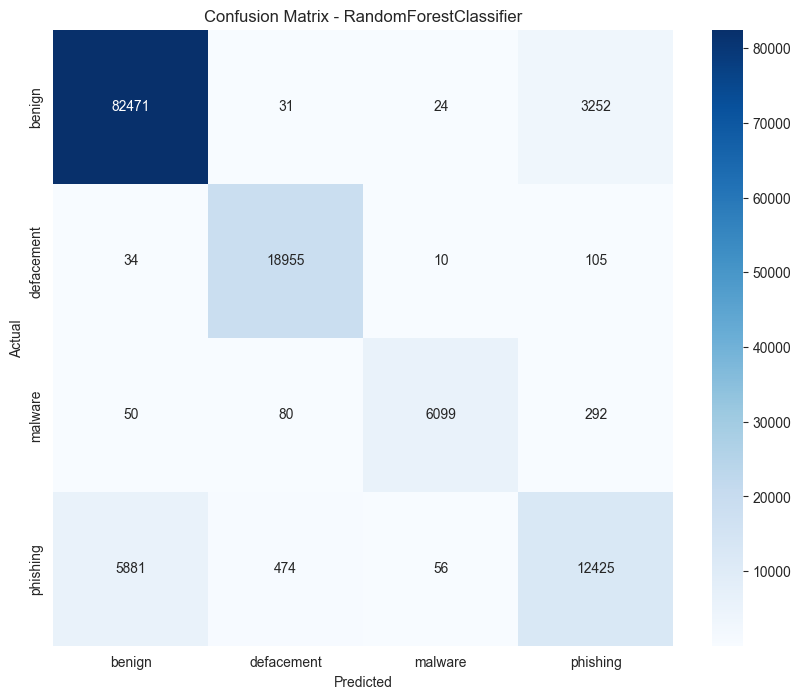

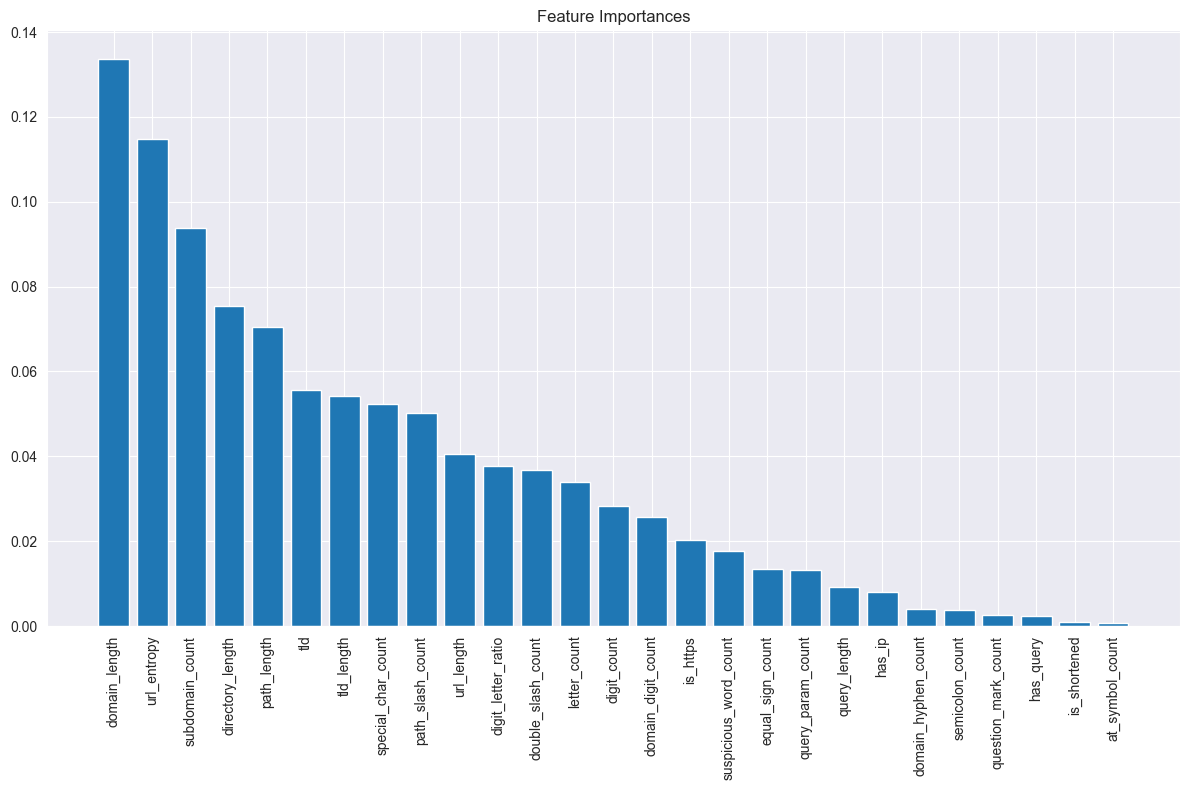


Training XGBoost...
XGBoost training finished in 4.99 seconds.

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     85778
           1       0.96      0.99      0.98     19104
           2       0.98      0.91      0.95      6521
           3       0.89      0.58      0.70     18836

    accuracy                           0.93    130239
   macro avg       0.94      0.87      0.89    130239
weighted avg       0.92      0.93      0.92    130239



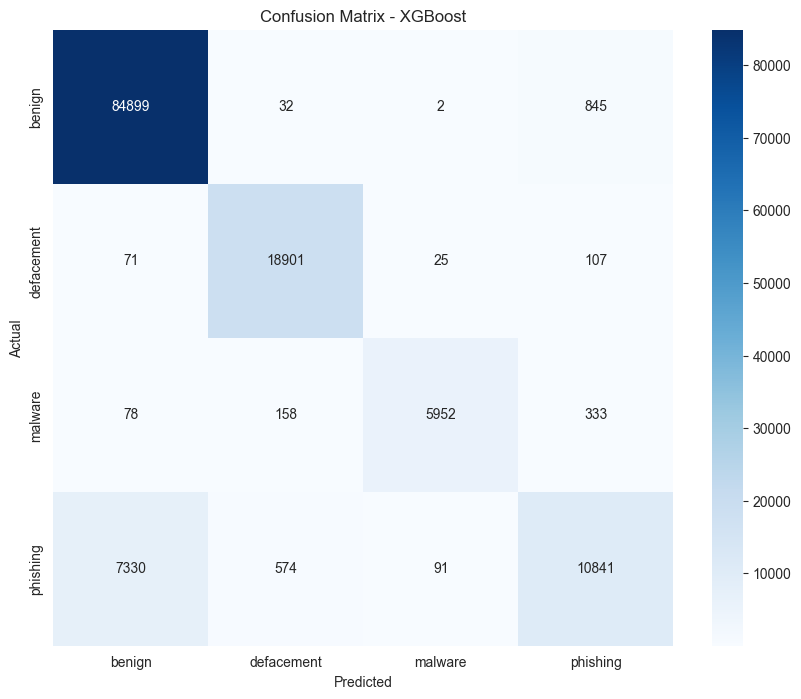

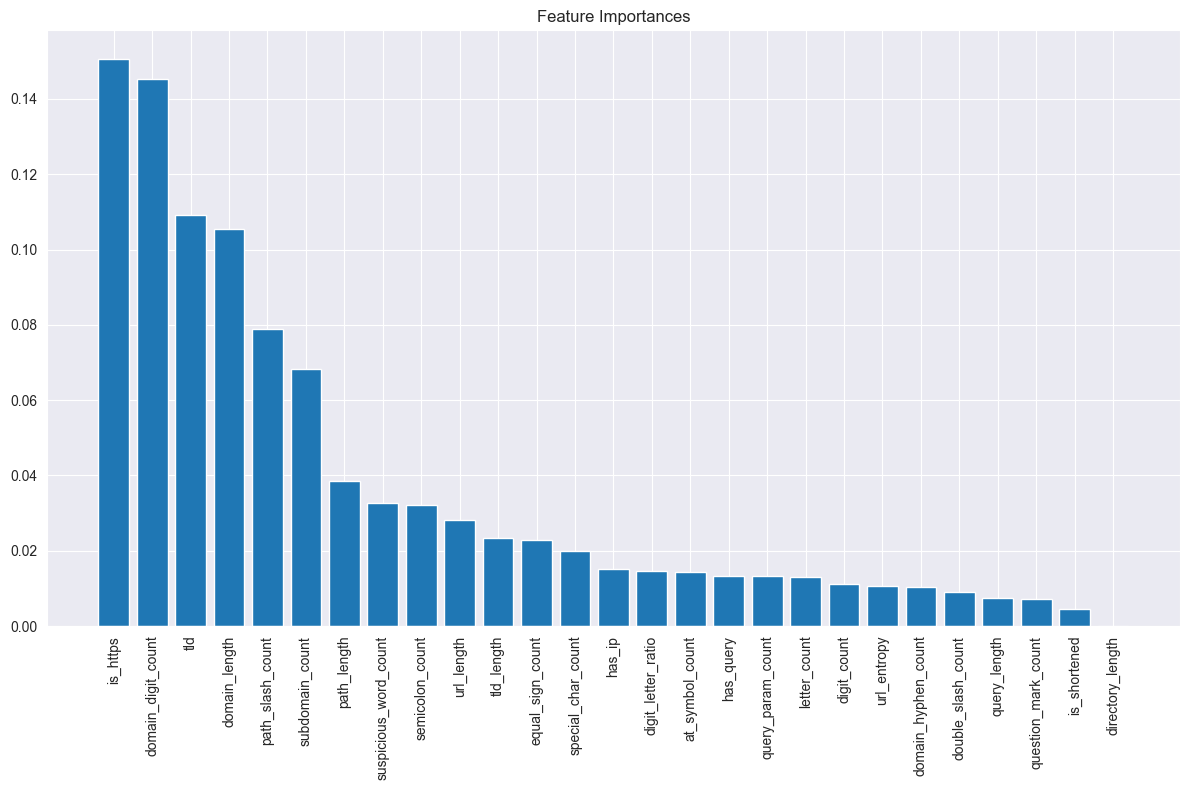


Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 520952, number of used features: 27
[LightGBM] [Info] Start training from score -0.419897
[LightGBM] [Info] Start training from score -1.907279
[LightGBM] [Info] Start training from score -2.997600
[LightGBM] [Info] Start training from score -1.934510
LightGBM training finished in 6.76 seconds.

Classification Report for LightGBM:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     85778
           1       0.96      0.99      0.97     19104
           2       0.97      0.90      0.93      6521
           3       0.89      0.57      0.69     18836

    accuracy                           0.92    130239
 

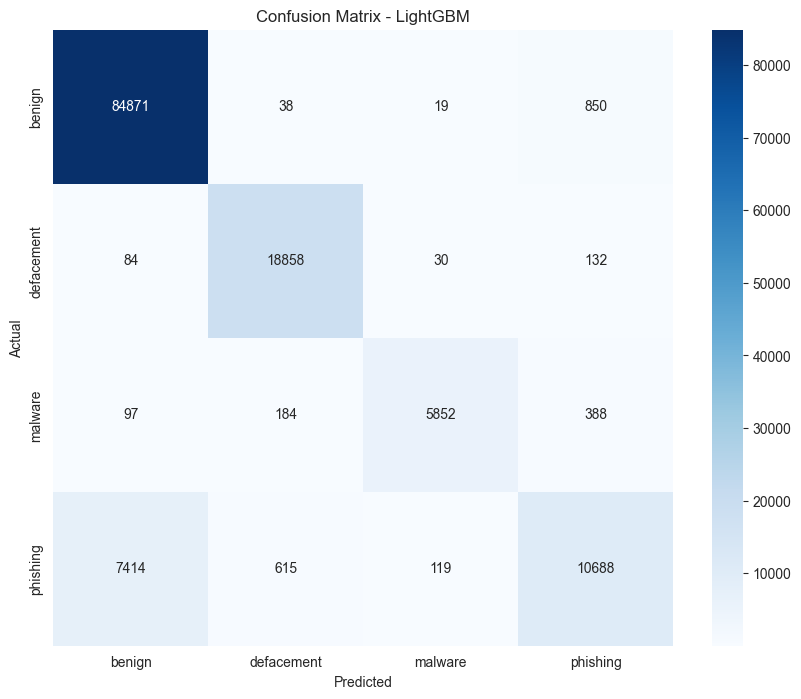

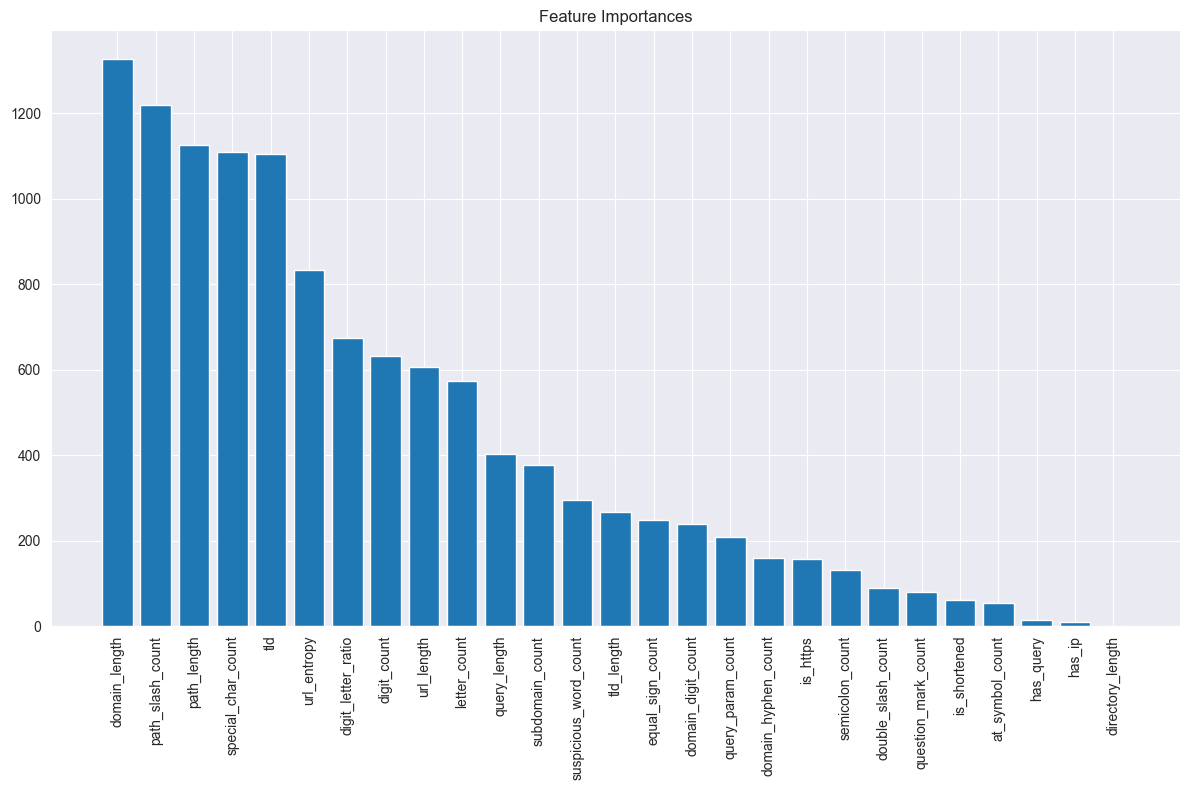


Training Naive Bayes...
Naive Bayes training finished in 0.21 seconds.

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88     85778
           1       0.78      0.54      0.64     19104
           2       0.25      0.81      0.38      6521
           3       0.22      0.04      0.06     18836

    accuracy                           0.73    130239
   macro avg       0.53      0.58      0.49    130239
weighted avg       0.72      0.73      0.70    130239



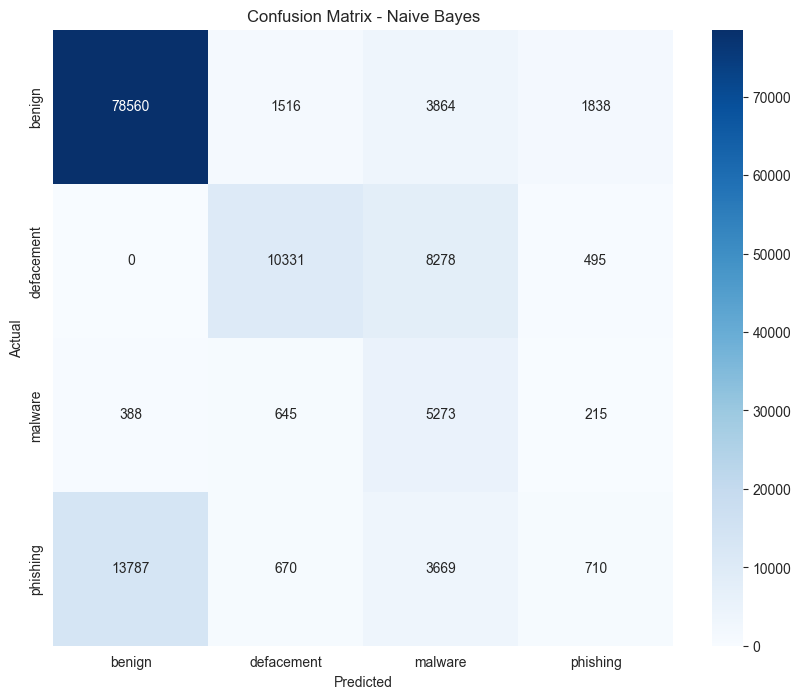


Training Decision Tree...
Decision Tree training finished in 4.63 seconds.

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     85778
           1       0.97      0.97      0.97     19104
           2       0.95      0.93      0.94      6521
           3       0.71      0.65      0.68     18836

    accuracy                           0.91    130239
   macro avg       0.89      0.88      0.88    130239
weighted avg       0.91      0.91      0.91    130239



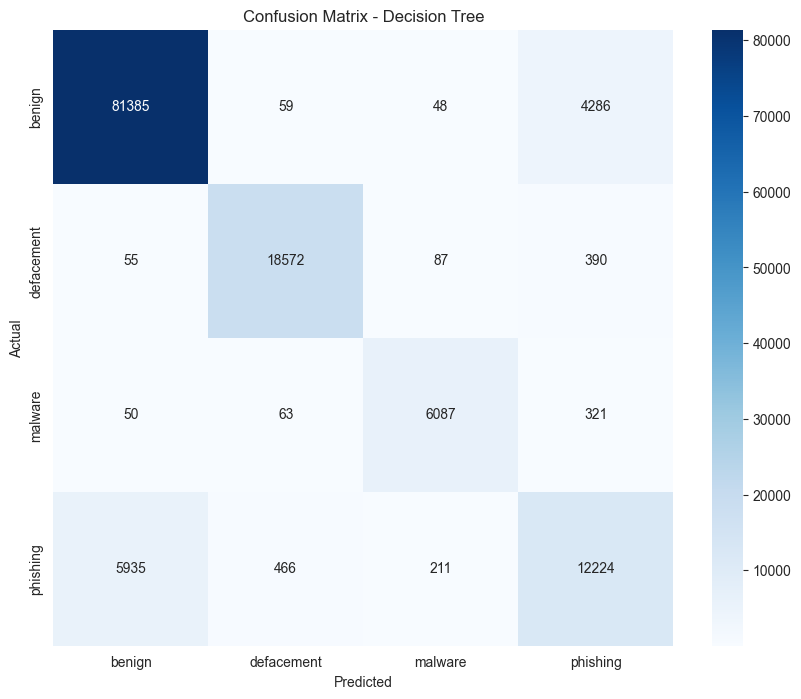

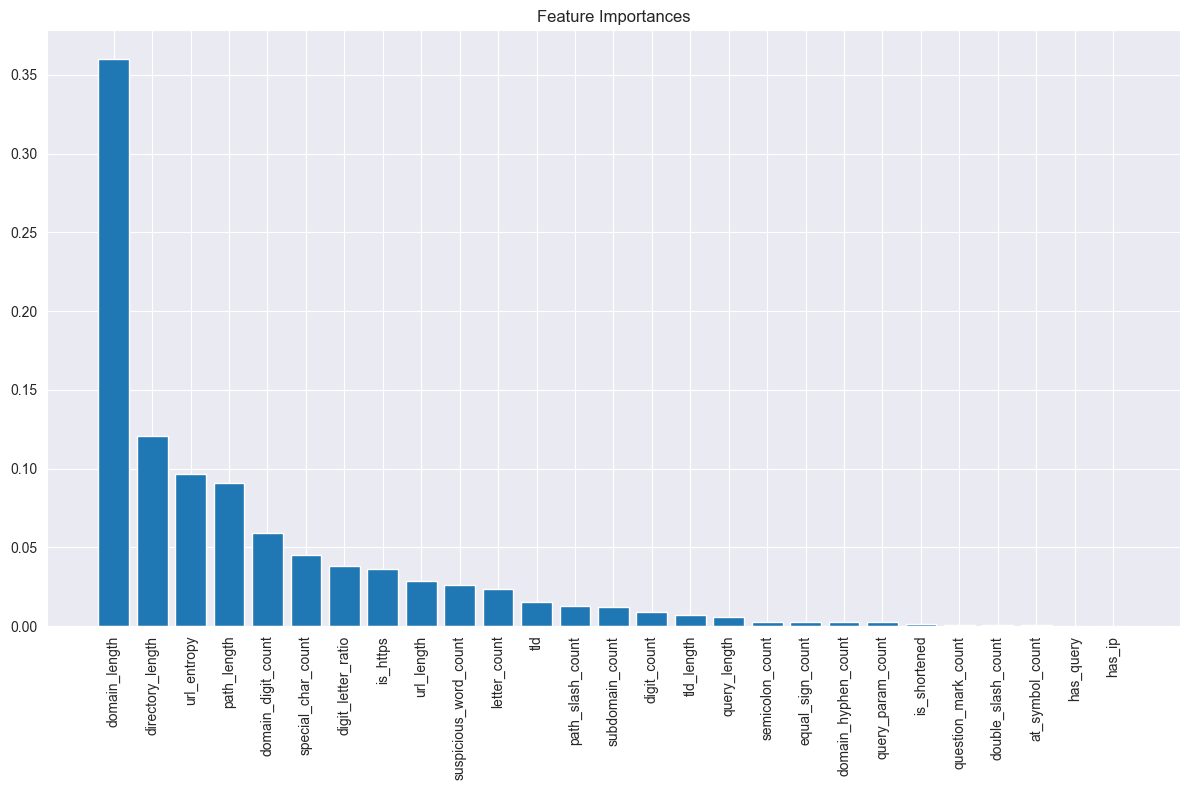


Training K-Nearest Neighbors...
K-Nearest Neighbors training finished in 0.13 seconds.

Classification Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     85778
           1       0.92      0.98      0.95     19104
           2       0.95      0.90      0.93      6521
           3       0.78      0.58      0.66     18836

    accuracy                           0.91    130239
   macro avg       0.89      0.86      0.87    130239
weighted avg       0.90      0.91      0.90    130239



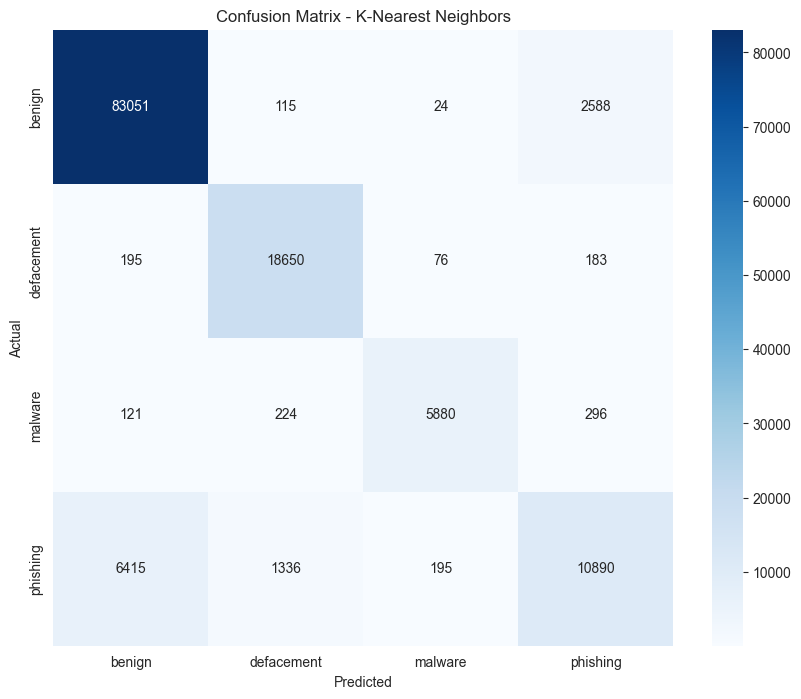


Training Logistic Regression...
Logistic Regression training finished in 159.25 seconds.

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.84      0.98      0.91     85778
           1       0.75      0.93      0.83     19104
           2       0.85      0.59      0.69      6521
           3       0.63      0.07      0.12     18836

    accuracy                           0.82    130239
   macro avg       0.77      0.64      0.64    130239
weighted avg       0.80      0.82      0.77    130239



C:\Users\tgweb\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


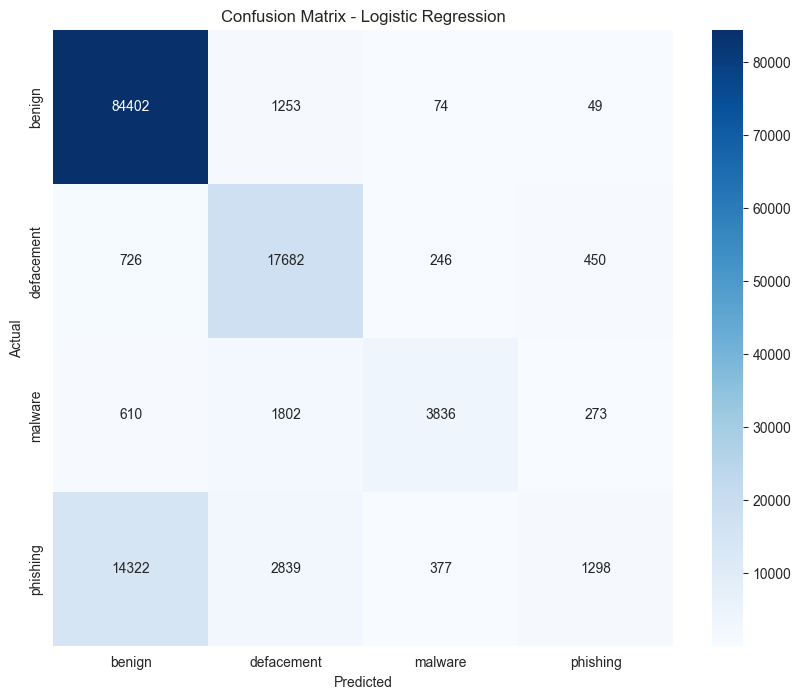


Training Multi-Layer Perceptron...
Multi-Layer Perceptron training finished in 657.59 seconds.

Classification Report for Multi-Layer Perceptron:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     85778
           1       0.88      0.96      0.92     19104
           2       0.93      0.77      0.84      6521
           3       0.81      0.55      0.66     18836

    accuracy                           0.90    130239
   macro avg       0.88      0.81      0.84    130239
weighted avg       0.90      0.90      0.89    130239



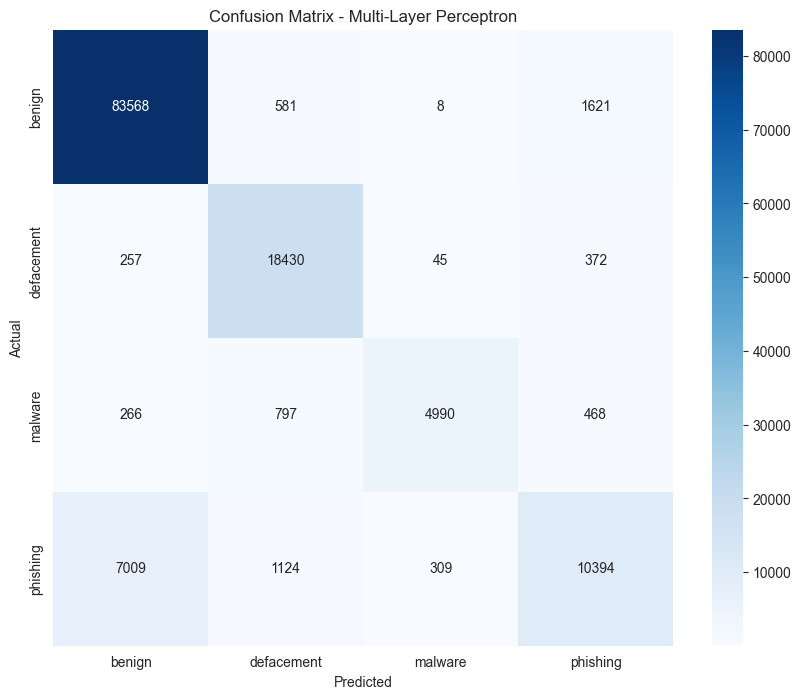

In [7]:
# Load the dataset
file_path = 'malicious_phish.csv'
df = load_data(file_path)

# Extract features
print("Extracting features from URLs...")
feature_df = create_feature_dataframe(df, url_column='url', label_column='type')

le_tld = LabelEncoder()
feature_df['tld'] = le_tld.fit_transform(feature_df['tld'])

# Split data into features and target
X = feature_df.drop('label', axis=1)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(feature_df['label'])

print(f"Feature extraction complete. Feature matrix shape: {X.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

rf_cls = RandomForestClassifier(n_estimators=100, random_state=42)
rf_cls = train_and_evaluate_model(rf_cls, 'RandomForestClassifier', X, X_train, X_test, y_train, y_test, label_encoder)

xgb_model = xgb.XGBClassifier(n_estimators=100, eval_metric='mlogloss', random_state=42)
xgb_model = train_and_evaluate_model(xgb_model, "XGBoost", X, X_train, X_test, y_train, y_test, label_encoder)

lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
lgb_model = train_and_evaluate_model(lgb_model, "LightGBM", X, X_train, X_test, y_train, y_test, label_encoder)

nb_model = MultinomialNB()
nb_model = train_and_evaluate_model(nb_model, "Naive Bayes", X, X_train, X_test, y_train, y_test, label_encoder)

dt_model = DecisionTreeClassifier(random_state=42)
dt_model = train_and_evaluate_model(dt_model, "Decision Tree", X, X_train, X_test, y_train, y_test, label_encoder)

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model = train_and_evaluate_model(knn_model, "K-Nearest Neighbors", X, X_train, X_test, y_train, y_test, label_encoder)

lr_model = LogisticRegression(max_iter=2000, solver='lbfgs')
lr_model = train_and_evaluate_model(lr_model, "Logistic Regression", X, X_train, X_test, y_train, y_test, label_encoder)

mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp_model = train_and_evaluate_model(mlp_model, "Multi-Layer Perceptron", X, X_train, X_test, y_train, y_test, label_encoder)

In [8]:
import joblib
joblib.dump(rf_cls, 'random_forest_model.joblib')
joblib.dump(xgb_model, 'xgboost_model.joblib')

['xgboost_model.joblib']

In [18]:
random_forest_model = joblib.load('random_forest_model.joblib')
xgboost_model = joblib.load('xgboost_model.joblib')

In [26]:
######DEMO######

# Select a random sample of 100 URLs from the test set
sample_indices = np.random.choice(len(X_test), size=100, replace=False)
X_demo = X_test.iloc[sample_indices]
y_demo_true = y_test[sample_indices]

# Predict using both models
xgb_preds = xgboost_model.predict(X_demo)
rf_preds = random_forest_model.predict(X_demo)

# Decode predictions and true labels
xgb_labels = label_encoder.inverse_transform(xgb_preds)
rf_labels = label_encoder.inverse_transform(rf_preds)
true_labels = label_encoder.inverse_transform(y_demo_true)

# Show results
demo_results = pd.DataFrame({
    'True Label': true_labels,
    'XGBoost Prediction': xgb_labels,
    'Random Forest Prediction': rf_labels
})

print("\nSample Predictions on 100 Test URLs:\n")
print(demo_results.head(20).to_string())

print("\nClassification Report: XGBoost on 100-sample Demo")
print(classification_report(y_demo_true, xgb_preds, target_names=label_encoder.classes_))

print("\nClassification Report: Random Forest on 100-sample Demo")
print(classification_report(y_demo_true, rf_preds, target_names=label_encoder.classes_))


Sample Predictions on 100 Test URLs:

    True Label XGBoost Prediction Random Forest Prediction
0       benign             benign                   benign
1   defacement         defacement               defacement
2   defacement         defacement               defacement
3       benign             benign                   benign
4       benign             benign                   benign
5       benign             benign                   benign
6     phishing         defacement                 phishing
7       benign             benign                   benign
8     phishing           phishing                 phishing
9     phishing             benign                   benign
10      benign             benign                   benign
11     malware            malware                  malware
12      benign             benign                 phishing
13      benign             benign                   benign
14     malware            malware                  malware
15      benign   